In [3]:
import sys
import os

sys.path.append(os.path.abspath(".."))
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import time

In [ ]:
def parse_category_txt(path: str) -> dict:
    import re

    category_map = {}
    current_key = None

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            # Detection of new key
            if ":" in line:
                # Example: "MSZoning: Identifies the zoning..."
                current_key = line.split(":")[0].strip()
                category_map[current_key] = []
            elif current_key:
                # Detect valid value - first "word" on the line
                parts = re.split(r"\s+", line)
                if parts and len(parts[0]) > 0:
                    # Ensures we don't accidentally add an empty string
                    category_map[current_key].append(parts[0])

    return category_map


data_categories = parse_category_txt("data_set\data_description.txt")
len(data_categories.keys())

# Load Data


Load train data


In [ ]:
path_train_data = "data_set/train.csv"

df_train = utils.load_csv_data(path_train_data)

# Print the loaded data
if isinstance(df_train, pd.DataFrame):
    print(f"dimension train data: {df_train.shape}")
    print(f"dimension train data: {type(df_train)}")
else:
    print("train_data is not a DataFrame")

del path_train_data

## use One-hot and scaler to prepare train data


In [7]:
def ensure_all_dummies(df: pd.DataFrame, data_categories: dict) -> pd.DataFrame:
    """
    Ensures that all expected dummy columns exist in the DataFrame.
    Adds missing columns with zero values in bulk to avoid fragmentation.
    """
    missing_cols = []
    for col, values in data_categories.items():
        for val in values:
            dummy_col = f"{col}_{val}"
            if dummy_col not in df.columns:
                missing_cols.append(dummy_col)

    if missing_cols:
        missing_df = pd.DataFrame(0, index=df.index, columns=missing_cols)
        df = pd.concat([df, missing_df], axis=1)

    return df

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

try:
    del x_encoded
except:
    print()


# 0. Extract and scale the target column
scaler_sale_price = StandardScaler()
y = scaler_sale_price.fit_transform(df_train[["SalePrice"]])  # shape: (n_samples, 1)

x = df_train.copy()
if "SalePrice" in x.columns:
    x = x.drop("SalePrice", axis=1)
if "Id" in x.columns:
    x = x.drop("Id", axis=1)

# 1. Split columns by data type
numerical_cols = x.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = x.select_dtypes(include=["object"]).columns.tolist()

# 2. Handle missing values
x[categorical_cols] = x[categorical_cols].fillna("NA")
x[numerical_cols] = x[numerical_cols].fillna(-1)

for col in data_categories.keys():
    if not col in x.columns:
        print(col)
        break

# 3. One-hot encode categorical features
x_encoded = pd.get_dummies(x, columns=categorical_cols)

# Ensure all dummy columns exist
x_encoded = ensure_all_dummies(x_encoded, data_categories)

# 4. Normalize numerical features
scaler_inputData = StandardScaler()
x_encoded[numerical_cols] = scaler_inputData.fit_transform(x_encoded[numerical_cols])

# 5. Define feature matrix
x = x_encoded

# 6. Split into training and validation sets
x_train_pd, x_val_pd, y_train_pd, y_val_pd = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# 7. Convert to NumPy arrays and cast to float32
x_train = x_train_pd.to_numpy().astype("float32")
x_val = x_val_pd.to_numpy().astype("float32")
y_train = y_train_pd.astype("float32")
y_val = y_val_pd.astype("float32")

# 8. Save original train columns for reuse
train_columns = x_encoded.columns.tolist()

print(x_train.shape)

In [ ]:
utils.analyze_data_distribution(df_train["SalePrice"], plot_hist=True)
utils.analyze_data_distribution(y_val, plot_hist=False)

In [ ]:
print("---- pandas dataframes ----")
print(type(x_train_pd))
print(x_train_pd.shape)
print(type(x_val_pd))
print(x_train.shape)
print(type(y_train_pd))
print(x_val_pd.shape)
print(type(y_val_pd))
print(x_val.shape)
print("---- numpy ----")
print(type(x_train))
print(y_train_pd.shape)
print(type(x_val))
print(y_train.shape)
print(type(y_train))
print(y_val_pd.shape)
print(type(y_val))
print(y_val.shape)

# Load test (target) data

In [ ]:
path_test_data = "data_set/test.csv"
path_submission_data = "data_set/sample_submission.csv"

test_data_df = utils.load_csv_data(path_test_data)
y_target_df = utils.load_csv_data(path_submission_data)

# Print the loaded data
if isinstance(test_data_df, pd.DataFrame):
    print(f"dimension train data: {test_data_df.shape}")
    print(f"dimension train data: {type(test_data_df)}")
else:
    print("train_data is not a DataFrame")

# Print the loaded data
if isinstance(y_target_df, pd.DataFrame):
    print(f"dimension train data: {y_target_df.shape}")
    print(f"dimension train data: {type(y_target_df)}")
else:
    print("train_data is not a DataFrame")

del path_test_data, path_submission_data

# print(type(test_data_df))
# print(type(y_target_df))
print(test_data_df.shape)
print(y_target_df.shape)

Prepare x_target data

In [ ]:
try:
    del x_target_encoded
except:
    print()


x_target = test_data_df.copy()

# 1. Drop nepotřebné sloupce
if "SalePrice" in x_target.columns:
    x_target = x_target.drop("SalePrice", axis=1)
if "Id" in x_target.columns:
    x_target = x_target.drop("Id", axis=1)

# 2. Missing values
x_target[categorical_cols] = x_target[categorical_cols].fillna("NA")
x_target[numerical_cols] = x_target[numerical_cols].fillna(-1)

# 3. One-hot encoding
x_target_encoded = pd.get_dummies(x_target, columns=categorical_cols)

# 4. Doplnění chybějících dummy sloupců
x_target_encoded = ensure_all_dummies(x_target_encoded, data_categories)

# 5. Znovu uspořádat a doplnit sloupce přesně podle train_columns
x_target_encoded = x_target_encoded.reindex(columns=train_columns, fill_value=0)

x_target_encoded[numerical_cols] = (
    x_target_encoded[numerical_cols].apply(pd.to_numeric, errors="coerce").fillna(-1)
)


x_target_encoded[numerical_cols] = scaler_inputData.transform(
    x_target_encoded[numerical_cols]
)

x_target_df = x_target_encoded.copy()

if "Id" in y_target_df.columns:
    y_target_df = y_target_df.drop("Id", axis=1)
y_target = y_target_df.to_numpy().astype("float32")

x_target = x_target_df.to_numpy().astype("float32")

print(type(x_target))
print(type(y_target))
print(type(x_target_df))
print(x_target.shape)
print(y_target.shape)
print(x_target_df.shape)

In [ ]:
utils.analyze_data_distribution(y_target_df["SalePrice"])
utils.analyze_data_distribution(df_train["SalePrice"], plot_hist=True)

# Prepare NetWork to learn

Train on 1168 samples, validate on 292 samples
Epoch 1/7
1168/1168 [==============================] - 0s 169us/sample - loss: 0.1687 - mae: 0.3342 - val_loss: 0.1185 - val_mae: 0.2643
Epoch 2/7
1168/1168 [==============================] - 0s 58us/sample - loss: 0.0884 - mae: 0.2031 - val_loss: 0.1001 - val_mae: 0.2277
Epoch 3/7
1168/1168 [==============================] - 0s 62us/sample - loss: 0.0722 - mae: 0.1678 - val_loss: 0.0929 - val_mae: 0.2178
Epoch 4/7
1168/1168 [==============================] - 0s 57us/sample - loss: 0.0629 - mae: 0.1460 - val_loss: 0.0895 - val_mae: 0.2158
Epoch 5/7
1168/1168 [==============================] - 0s 61us/sample - loss: 0.0569 - mae: 0.1322 - val_loss: 0.0849 - val_mae: 0.2073
Epoch 6/7
1168/1168 [==============================] - 0s 69us/sample - loss: 0.0524 - mae: 0.1280 - val_loss: 0.0842 - val_mae: 0.2094
Epoch 7/7
1168/1168 [==============================] - 0s 58us/sample - loss: 0.0491 - mae: 0.1267 - val_loss: 0.0787 - val_mae: 0.1981


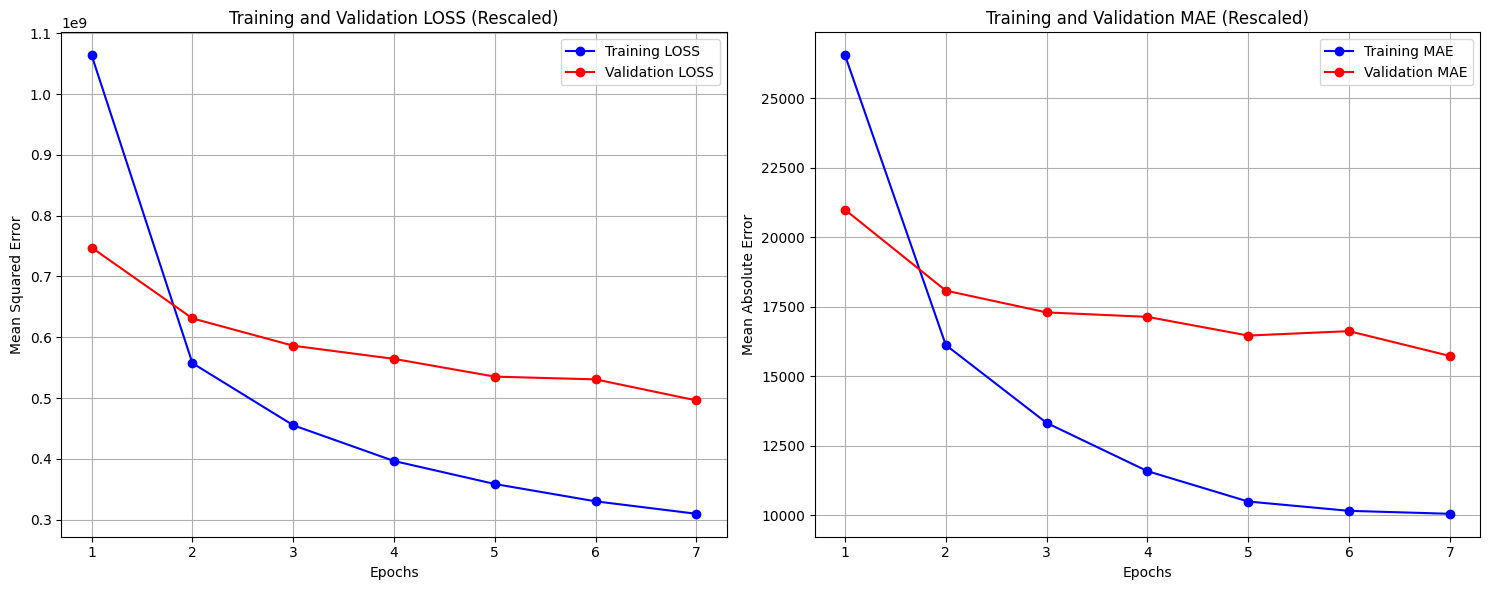

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

start = time.time()
early_stop = EarlyStopping(monitor="val_mae", patience=5, restore_best_weights=True)

model = Sequential(
    [
        Dense(
            32,
            activation="relu",
            input_shape=(x_train.shape[1],),
            kernel_regularizer=l2(0.001),
        ),
        Dense(16, activation="relu", kernel_regularizer=l2(0.001)),
        Dense(1),
    ]
)

# model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.compile(optimizer="adam", loss="huber", metrics=["mae"])

history = model.fit(
    x_train,
    y_train,
    epochs=7,
    validation_data=(x_val, y_val),
    batch_size=16,
    # callbacks=[early_stop],
    # verbose=0,
)

print(f"🕒 Celkový čas trénování: {time.time() - start:.2f} s")

val_mse, val_mae = model.evaluate(x_val, y_val, verbose=0)
print(f"- ✅ finished: val_mae = {val_mae:.2f}")
print(f"- ✅ finished: val_mse = {val_mse:.2f}")
val_mae_usd = val_mae * scaler_sale_price.scale_[0]
val_rmse_usd = (val_mse * (scaler_sale_price.scale_[0] ** 2)) ** 0.5
print(f"- ✅ finished: val_mae = ~${val_mae_usd:,.0f}")
print(f"- ✅ finished: val_rmse = ~${val_rmse_usd:,.0f}")
utils.plot_rescaled_history(
    history.history, metric="loss", metric2="mae", scaler=scaler_sale_price
)

# Test build model


## Test on validation data


C:\Users\Uzivatel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


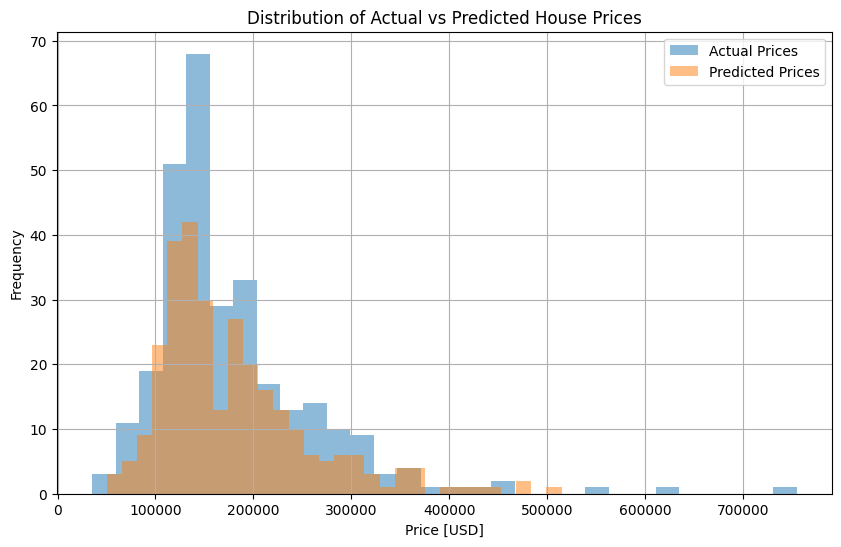

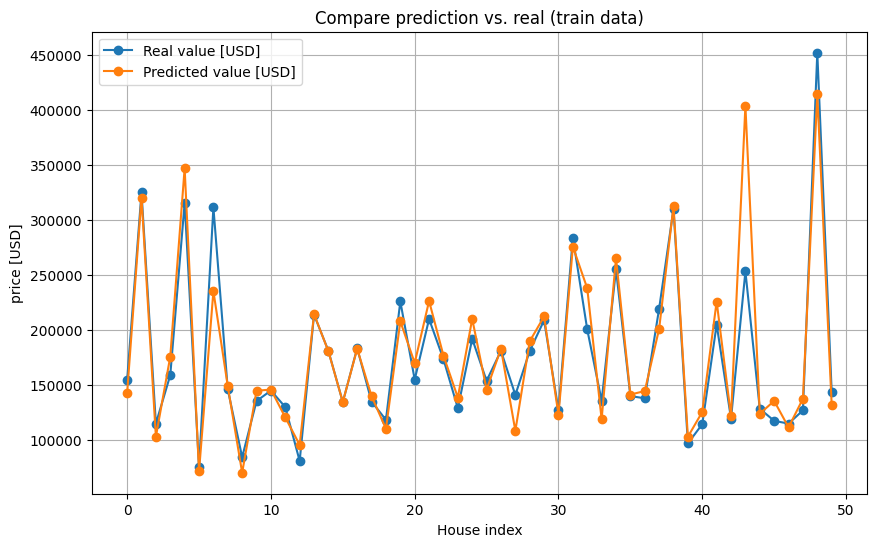

In [58]:
# Předpověď na testovacích datech
y_pred_scaled = model.predict(x_val)

# Inverze zpět na reálné ceny
y_pred_real = scaler_sale_price.inverse_transform(y_pred_scaled)
y_test_real = scaler_sale_price.inverse_transform(y_val.reshape(-1, 1))


# Výstup porovnání
results = pd.DataFrame(
    {"Actual": y_test_real.flatten(), "Predicted": y_pred_real.flatten()}
)

# Create histogram plot
plt.figure(figsize=(10, 6))
plt.hist(results["Actual"], bins=30, alpha=0.5, label="Actual Prices")
plt.hist(results["Predicted"], bins=30, alpha=0.5, label="Predicted Prices")
plt.xlabel("Price [USD]")
plt.ylabel("Frequency")
plt.title("Distribution of Actual vs Predicted House Prices")
plt.legend()
plt.grid(True)
plt.show()

count = len(x_val)
count = 50
# print(results.head(count))

plt.figure(figsize=(10, 6))
plt.plot(results["Actual"][:count], marker="o", label="Real value [USD]")
plt.plot(results["Predicted"][:count], marker="o", label="Predicted value [USD]")
plt.title("Compare prediction vs. real (train data)")
plt.xlabel("House index")
plt.ylabel("price [USD]")
plt.legend()
plt.grid(True)
plt.show()

## Test on test data


Load test data


In [64]:
y_pred_scaled = model.predict(x_target)

y_pred_real = scaler_sale_price.inverse_transform(y_pred_scaled)

results = pd.DataFrame({"Actual": "who know", "Predicted": y_pred_real.flatten()})

count = 50
# print(round(results.head(count)))

plt.figure(figsize=(10, 6))
plt.plot(results["Actual"][:count], marker="o", label="Real value [USD]")
plt.plot(results["Predicted"][:count], marker="o", label="Predicted value [USD]")
plt.title("Compare prediction vs. real (target data)")
plt.xlabel("House index")
plt.ylabel("price [USD]")
plt.legend()
plt.grid(True)
plt.show()

Save data for kaggle

In [60]:
# Předpokládám, že máš predikce:
# y_pred_real = výstup modelu, shape (n, 1)
# test_data_df = původní `test.csv` DataFrame

submission_df = pd.DataFrame(
    {"Id": test_data_df["Id"], "SalePrice": y_pred_real.flatten()}
)

# Uložení pro Kaggle
submission_df.to_csv("submission.csv", index=False)

# Compare train and target data drift

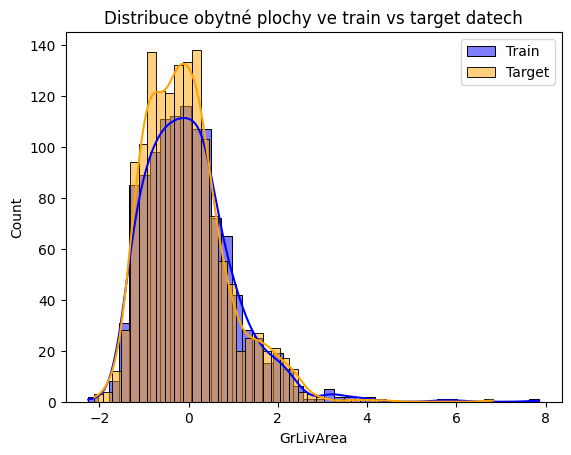

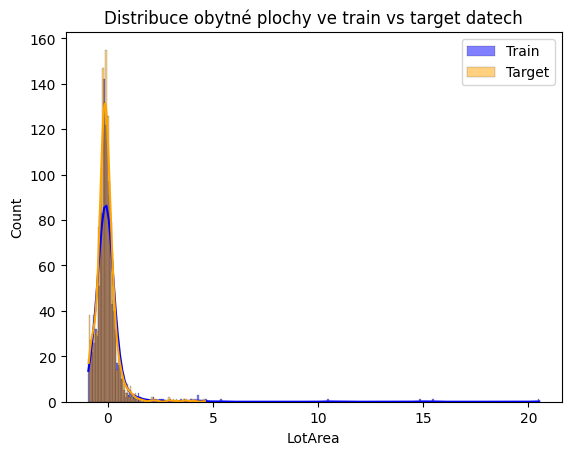

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

show_col = "GrLivArea"
sns.histplot(x_train_pd[show_col], color="blue", label="Train", kde=True)
sns.histplot(x_target_df[show_col], color="orange", label="Target", kde=True)
plt.legend()
plt.title("Distribuce obytné plochy ve train vs target datech")
plt.show()

show_col = "LotArea"
sns.histplot(x_train_pd[show_col], color="blue", label="Train", kde=True)
sns.histplot(x_target_df[show_col], color="orange", label="Target", kde=True)
plt.legend()
plt.title("Distribuce obytné plochy ve train vs target datech")
plt.show()

<Axes: xlabel='SalePrice', ylabel='Count'>

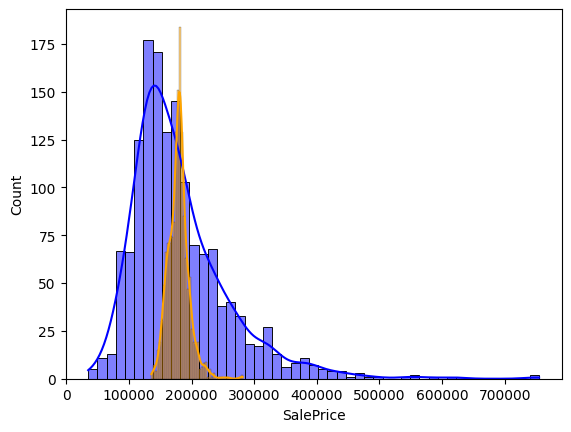

# show histograms for all columns
Do not click

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # show histograms for all columns
# for col in x_train_pd.columns:
#     # Zkontrolujeme, jestli je sloupec číselný
#     if not pd.api.types.is_numeric_dtype(x_train_pd[col]):
#         continue  # přeskočíme např. stringové/kategoriální sloupce

#     plt.figure(figsize=(8, 4))
#     sns.histplot(x_train_pd[col], color="blue", label="Train", kde=True, stat="density")
#     sns.histplot(
#         x_target_df[col], color="orange", label="Target", kde=True, stat="density"
#     )
#     plt.legend()
#     plt.title(f"Distribuce sloupce: {col}")
#     plt.xlabel(col)
#     plt.tight_layout()
#     plt.show()